In [1]:
%matplotlib inline

import sys
import units
import constants_noh as constants
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
from astropy import units as u
from astropy.coordinates import SkyCoord
from tqdm import *

sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/Modules/")
# My Functions
from AssortedFunctions import myLog

In [18]:
def SpatialDist(r):
    return 0.50 * np.exp( (-2./2.20 * ( (r/(0.65*311 * units.kpc))**(2.20) - 1 ) ) )

a, b, c = -5.384, 1.156, -0.056
def rmax(Mvir):
    rmax = 10**( a + b*np.log10(Mvir/units.M_s) + c*(np.log10(Mvir/units.M_s))**2 )*units.kpc
    return np.random.normal(rmax, 0.145*units.kpc)

def DensityProfNorm(Mvir, Rvir, r_s):
    return Mvir / quad( lambda r: 4*np.pi*r**2 * np.exp( -2./0.16 * ( (r/r_s)**(0.16) - 1 )), 0, Rvir  )[0]

r_s_NFW = 17.356636256189983 * units.kpc
r_E = 8.5 * units.kpc

def Rvir_NFW(Mvir, r):
    rho_0 = 0.4 * units.GeV/units.Centimeter**3 * (r_E/r_s_NFW) * (1 + r_E/r_s_NFW)**2
    Mltr = 4 * np.pi * rho_0 * r_s_NFW**3 * ( np.log( (r_s_NFW + r)/r_s_NFW ) - r/(r_s_NFW + r) )
    dlnMdlnR = ( np.log(1 + r/r_s_NFW) - r/(r_s_NFW + r) )**(-1) * (r/(r_s_NFW + r))**2
    return ( Mvir / ( (2 - dlnMdlnR)*Mltr ) )**(1./3.) * r

def J_fac_int(Mvir, r):
    
    #Rvir = 4 * np.pi * r_s_NFW**3 * 0.4 * units.GeV/units.Centimeter**3 * r_E/r_s_NFW * ( 1 + r_E/r_s_NFW )**2 * (np.log(1+r/r_s_NFW) - r / (r_s_NFW + r) )
    #Rvir = ((Mvir / ((2 - *Rvir))**(1/3))*r
    
    Rvir = Rvir_NFW(Mvir, r)
    r_s = rmax(Mvir) / 2.189
    c = Rvir/r_s
    return r_s, Mvir**2 * c**3 / (12 * np.pi * Rvir**3) * ( 1 - (1+c)**(-3) ) * ( np.log(1+c) - c/(1+c) )**(-2)
    #return quad( lambda r: 4*np.pi*r**2 * ( DensityProfNorm(Mvir, Rvir, r_s) * np.exp( -2./0.16 * ( (r/r_s)**(0.16) - 1 ) ) )**2, 0, Rvir )[0]
'''
def Ein_norm(Mvir, r):
    Rvir = Rvir_NFW(Mvir, r)
    return Mvir/quad(lambda x: 4 * np.pi * x**2 * rho_Ein(x, r, Mvir), 0, Rvir )[0]
    
def rho_Ein(r, rt, Mvir):
    Rvir = Rvir_NFW(Mvir, rt)
    r_s = rmax(Mvir) / 2.189
    
    return np.exp( -2./0.16 * ( (r/r_s)**(0.16) - 1 ) )

def r_halocentric(r, l, psi_deg):
    return np.sqrt(r**2. + l**2. - 2.*r*l*np.cos(np.radians(psi_deg)))

def J_fac_integral(r, psi_deg, Mvir):
    rho_0 = Ein_norm(Mvir, r)
    return quad(lambda l: rho_0 * rho_Ein(r_halocentric(r, l, psi_deg), r, Mvir)**2, 0., 1000.)[0]

def J_fac_total(Mvir, r):
    r_s = rmax(Mvir) / 2.189
    psi_deg = np.arange(0., 180.5, 0.5)
    return r_s, 2*np.pi*quad(lambda psi: np.sin(np.radians(psi))*J_fac_integral(r, psi, Mvir), 0., 180.)[0]
'''
def Pass_Vmax_Cut( Mvir, r ):
    Rvir = Rvir_NFW(Mvir, r)
    r_s = rmax(Mvir) / 2.189
    val = Mvir/units.M_s * 0.473285312/(np.log((Rvir + r_s)/r_s) - Rvir/(r_s + Rvir))
    return val >= 3542325.58

In [19]:
mMin = 5.4e6*units.M_s
mMax = 1e10*units.M_s

In [20]:
trials = 100
xsec = 1e-25
mDM = 100
channel = 'b'
N_calib = 300.
mMin_calib = 1e8*units.M_s
mMax_calib = 1e10*units.M_s
N_subs = round(N_calib / ( -.9**(-1) * (mMax_calib**(-.9) - mMin_calib**(-.9))) * -.9**(-1) * (mMax**(-.9) - mMin**(-.9))) # Total number of subhalos
N_subs = round(1.77e12 * .038*units.M_s * .1 / (mMax**(.1) - mMin**(.1)) * (mMin**(-.9) - mMax**(-.9))/.9)
#N_subs = np.random.poisson(N_subs)
print(N_subs)

1232


In [21]:
ebins = [.1,100]

dNdLogx_df = pd.read_csv('Data/AtProduction_gammas.dat', delim_whitespace=True)
dNdLogx_ann_df = dNdLogx_df.query('mDM == ' + (str(np.int(float(mDM)))))[['Log[10,x]',channel]]
Egamma = np.array(mDM*(10**dNdLogx_ann_df['Log[10,x]']))
dNdEgamma = np.array(dNdLogx_ann_df[channel]/(Egamma*np.log(10)))
dNdE_interp = interp1d(Egamma, dNdEgamma)
if ebins[0] < mDM:
    if ebins[1] < mDM:
        # Whole bin is inside
        PPnoxsec = 1.0/(8*np.pi*mDM**2)*quad(lambda x: dNdE_interp(x), ebins[0], ebins[1])[0]
    else:
        # Bin only partially contained
        PPnoxsec = 1.0/(8*np.pi*mDM**2)*quad(lambda x: dNdE_interp(x), ebins[0], mDM)[0]

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


In [22]:
rvals_sel = np.logspace(1, np.log10(311*units.kpc), 60000)
cum_r = []
for rt in rvals_sel:
    cum_r.append( quad( lambda r: r**2 * SpatialDist(r), 0, rt )[0] )
cum_r = np.array(cum_r)/cum_r[-1]

In [23]:
flux = []
mval_arr_arr = []
rs_arr_arr = []
dA_arr_arr = []
for trial in tqdm_notebook(range(trials)):
    rands = np.random.rand(N_subs)
    rval_arr = np.interp(rands, cum_r, rvals_sel)
    rands = np.random.rand(N_subs)
    mval_arr = ( mMin**(-.9) + rands*(mMax**(-.9) - mMin**(-.9)) )**(-1/.9)
    mval_arr_arr.append(mval_arr)
    theta_arr = np.arccos( 2*np.random.rand(N_subs) - 1 )
    phi_arr = 2*np.pi*np.random.rand(N_subs)
    rs_arr = np.zeros(N_subs)
    
    PS_list = SkyCoord(x=rval_arr*np.cos(phi_arr)*np.sin(theta_arr)/units.kpc*u.kpc, 
                       y=rval_arr*np.sin(phi_arr)*np.sin(theta_arr)/units.kpc*u.kpc,
                       z=rval_arr*np.cos(theta_arr)/units.kpc*u.kpc, frame="galactocentric").transform_to("galactic")
    
    cut = Pass_Vmax_Cut( mval_arr, rval_arr )
    dA_arr = PS_list.distance.value*units.kpc
    dA_arr_arr.append(dA_arr)
    flux_arr = []
    J_arr = []
    for i in (range(N_subs)):
        r_s, J_int = J_fac_int( mval_arr[i], rval_arr[i] )
        rs_arr[i] = r_s
        if cut[i]: flux_arr.append( xsec * PPnoxsec * J_int / dA_arr[i]**2 / (units.Centimeter**(-5) * units.GeV**2) * cut[i])
        else: flux_arr.append(0)
        J_arr.append(flux_arr[-1]/(xsec*PPnoxsec))
    flux.append(flux_arr)
    rs_arr_arr.append(rs_arr)

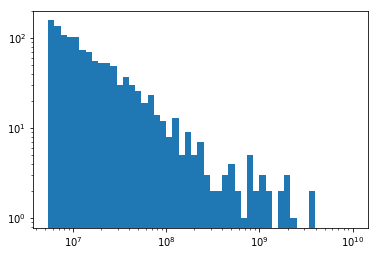

In [24]:
plt.hist(mval_arr/units.M_s, bins=np.logspace(np.log10(mMin/units.M_s), np.log10(mMax/units.M_s)))
plt.yscale("log")
plt.xscale("log")

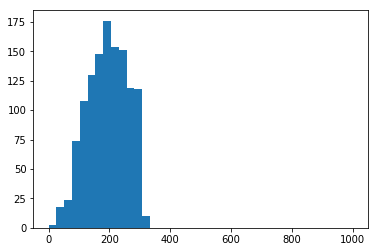

In [25]:
plt.hist(rval_arr/units.kpc, np.linspace(0,1000,40));

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log10
  # This is added back by InteractiveShellApp.init_path()


Text(0.5,0,'log$_{10}F$ [counts cm$^{-2}$s$^{-1}$]')

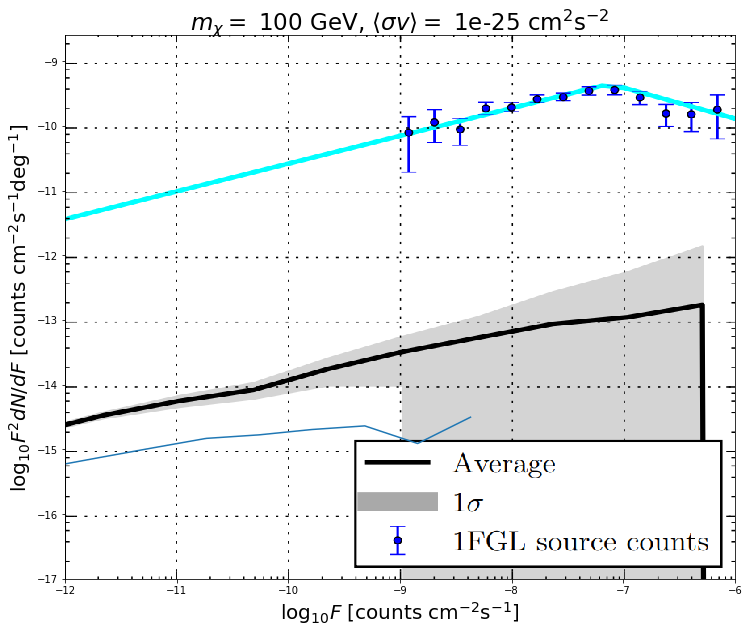

In [26]:
plt.figure(figsize=(12,10))
img = plt.imread("../../PltImg/161103503.png")
plt.imshow(img, extent=[-12,-6, -17,myLog(2.7e-9)], aspect='auto')
dN = np.zeros(19)
for flux_arr in flux:
    bins = np.histogram(flux_arr, bins=np.logspace(-15, -6, 20))

    dN += bins[0]/(4*np.pi*(180/np.pi)**2)/trials
F = bins[1][:-1]
dF = np.diff(bins[1])
plt.plot(myLog(F), np.log10(F**2 * dN/dF))
plt.ylim(-17, myLog(2.5e-9))
plt.xlim(-12, -6)
plt.title("$m_{\chi} =$ 100 GeV, $\\langle \\sigma v \\rangle = $ 1e-25 cm$^2$s$^{-2}$", fontsize=23)
plt.ylabel("log$_{10}F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-1}$]", fontsize=20)
plt.xlabel("log$_{10}F$ [counts cm$^{-2}$s$^{-1}$]", fontsize=20)

(0, 120)

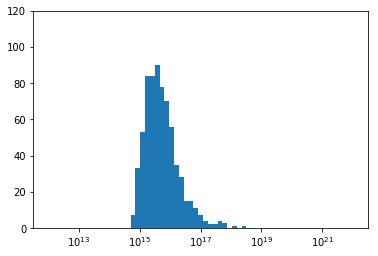

In [11]:
plt.hist(J_arr, bins=np.logspace(12, 22, 64))
plt.xscale("log")
plt.ylim(0,120)

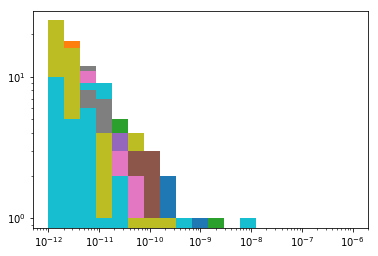

In [12]:
for flux_arr in flux:
    plt.hist(flux_arr, bins=np.logspace(-12, -6, 20));
plt.yscale("log")
plt.xscale("log")

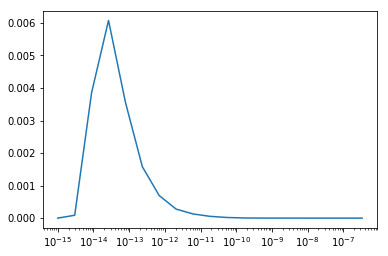

In [13]:
plt.plot(F, dN)
#plt.yscale("log")
plt.xscale("log")

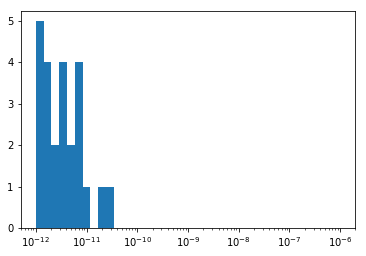

In [14]:
plt.hist(xsec*PPnoxsec*np.array(J_arr), bins=np.logspace(-12,-6,40));
plt.xscale("log")

(50000000000000.0, 1e+21)

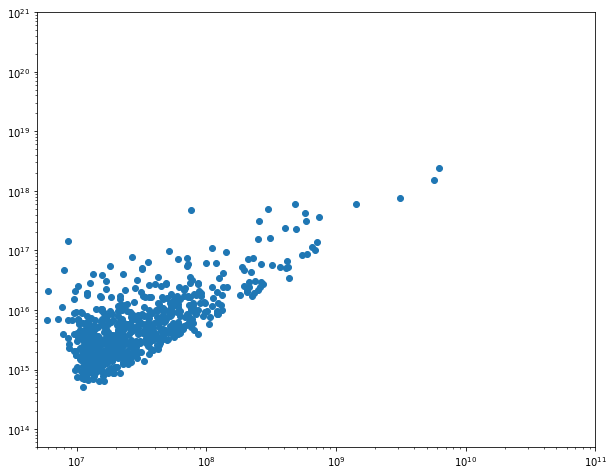

In [15]:
plt.figure(figsize=(10,8))
plt.scatter(mval_arr/units.M_s, J_arr)
plt.yscale("log")
plt.xscale("log")
plt.xlim(5e6, 1e11)
plt.ylim(5e13, 1e21)

(4000000.0, 100000000000.0)

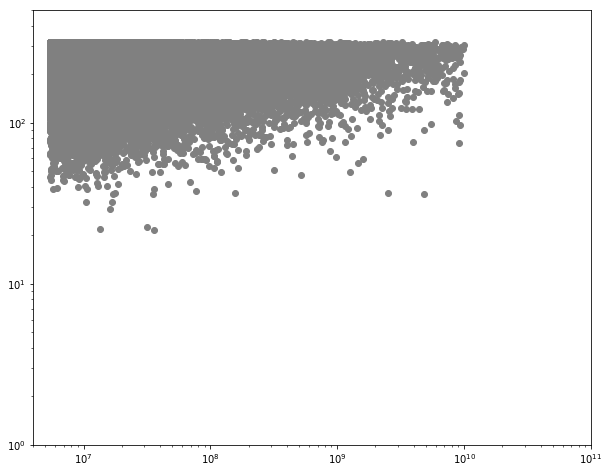

In [16]:
plt.figure(figsize=(10,8))
for im, mval_arr in enumerate(mval_arr_arr):
    plt.scatter(mval_arr/units.M_s, dA_arr_arr[im]/units.kpc, c="grey")
plt.yscale("log")
plt.xscale("log")
plt.ylim(1, 500)
plt.xlim(4e6, 1e11)

(4000000.0, 100000000000.0)

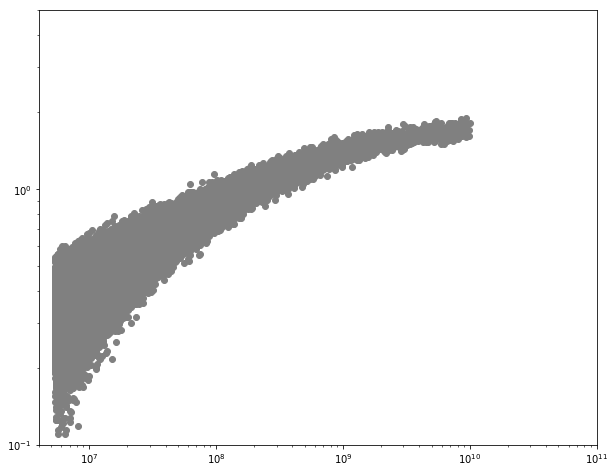

In [17]:
plt.figure(figsize=(10,8))
for im, mval_arr in enumerate(mval_arr_arr):
    plt.scatter(mval_arr/units.M_s, rs_arr_arr[im]/units.kpc, c="grey")
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-1, 5)
plt.xlim(4e6, 1e11)